In [1]:
# ============================================
# CELL 1: SETUP & INSTALLATIONS
# ============================================

print("="*70)
print(" "*15 + "FEW-SHOT LEARNING PROJECT")
print(" "*10 + "Prototypical Networks on Omniglot")
print("="*70)

import sys
import subprocess
import warnings
warnings.filterwarnings('ignore')

# Install required packages
def install_packages():
    packages = ['torch', 'torchvision', 'numpy', 'matplotlib', 
                'pillow', 'tqdm', 'scikit-learn', 'seaborn']
    
    print("\nInstalling required packages...")
    for package in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 
                             'install', '-q', package])
    print("✓ All packages installed!\n")

install_packages()

               FEW-SHOT LEARNING PROJECT
          Prototypical Networks on Omniglot

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 22.9 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


✓ All packages installed!



In [2]:
!pip uninstall -y libcugraph-cu12 pylibcugraph-cu12 libraft-cu12 pylibraft-cu12 rmm-cu12
!pip install \
  libcugraph-cu12==25.6.0 \
  pylibcugraph-cu12==25.6.0 \
  libraft-cu12==25.6.0 \
  pylibraft-cu12==25.6.0 \
  rmm-cu12==25.6.0


Found existing installation: libcugraph-cu12 25.6.0
Uninstalling libcugraph-cu12-25.6.0:
  Successfully uninstalled libcugraph-cu12-25.6.0
Found existing installation: pylibcugraph-cu12 25.6.0
Uninstalling pylibcugraph-cu12-25.6.0:
  Successfully uninstalled pylibcugraph-cu12-25.6.0
Found existing installation: libraft-cu12 25.2.0
Uninstalling libraft-cu12-25.2.0:
  Successfully uninstalled libraft-cu12-25.2.0
Found existing installation: pylibraft-cu12 25.2.0
Uninstalling pylibraft-cu12-25.2.0:
  Successfully uninstalled pylibraft-cu12-25.2.0
Found existing installation: rmm-cu12 25.2.0
Uninstalling rmm-cu12-25.2.0:
  Successfully uninstalled rmm-cu12-25.2.0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4

In [3]:
# ============================================
# CELL 2: IMPORTS & CONFIGURATION
# ============================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from pathlib import Path
import zipfile
import requests
from collections import defaultdict
import json
import time
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}\n")

Using device: cuda
GPU: Tesla P100-PCIE-16GB



In [4]:
# ============================================
# CELL 3: CONFIGURATION CLASS
# ============================================

class Config:
    """Project configuration"""
    
    # Model settings
    MODEL_TYPE = 'prototypical'
    HIDDEN_DIM = 64
    
    # Few-shot settings
    N_WAY_TRAIN = 5
    N_SHOT_TRAIN = 5
    N_QUERY_TRAIN = 10
    
    N_WAY_TEST = 5
    N_SHOT_TEST = 5
    N_QUERY_TEST = 15
    
    # Training
    N_EPISODES_TRAIN = 100
    N_EPISODES_VAL = 50
    N_EPOCHS = 30  # Reduced for Kaggle
    
    # Optimization
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    LR_STEP_SIZE = 10
    LR_GAMMA = 0.5
    
    # Paths
    DATA_DIR = './data'
    CHECKPOINT_DIR = './checkpoints'
    RESULTS_DIR = './results'
    DEVICE = device
    
    # Logging
    PRINT_FREQ = 10
    SAVE_FREQ = 5

config = Config()

# Create directories
Path(config.DATA_DIR).mkdir(exist_ok=True)
Path(config.CHECKPOINT_DIR).mkdir(exist_ok=True)
Path(config.RESULTS_DIR).mkdir(exist_ok=True)

print("Configuration:")
print(f"  Model: {config.MODEL_TYPE}")
print(f"  Training: {config.N_WAY_TRAIN}-way {config.N_SHOT_TRAIN}-shot")
print(f"  Testing: {config.N_WAY_TEST}-way {config.N_SHOT_TEST}-shot")
print(f"  Epochs: {config.N_EPOCHS}")
print(f"  Device: {config.DEVICE}\n")

Configuration:
  Model: prototypical
  Training: 5-way 5-shot
  Testing: 5-way 5-shot
  Epochs: 30
  Device: cuda



In [5]:
# ============================================
# CELL 4: DATASET DOWNLOAD
# ============================================

print("="*70)
print("DOWNLOADING OMNIGLOT DATASET")
print("="*70)

class OmniglotDownloader:
    def __init__(self, root_dir='./data'):
        self.root_dir = Path(root_dir)
        self.urls = {
            'background': 'https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip',
            'evaluation': 'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip'
        }
    
    def download(self):
        for split, url in self.urls.items():
            zip_path = self.root_dir / f'{split}.zip'
            extract_path = self.root_dir / 'omniglot'
            
            if extract_path.exists() and len(list(extract_path.rglob('*.png'))) > 19000:
                print(f"✓ {split} set already exists")
                continue
            
            print(f"\nDownloading {split} set...")
            response = requests.get(url, stream=True)
            total = int(response.headers.get('content-length', 0))
            
            with open(zip_path, 'wb') as f, tqdm(total=total, unit='iB', unit_scale=True) as pbar:
                for chunk in response.iter_content(8192):
                    f.write(chunk)
                    pbar.update(len(chunk))
            
            print(f"Extracting {split}...")
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(self.root_dir / 'omniglot')
            
            zip_path.unlink()
            print(f"✓ {split} complete!")
        
        print("\n✓ Dataset download complete!")
        self.print_info()
    
    def print_info(self):
        omniglot_path = self.root_dir / 'omniglot'
        total_chars = 0
        total_imgs = 0
        
        for split in ['images_background', 'images_evaluation']:
            split_path = omniglot_path / split
            if split_path.exists():
                for alphabet in split_path.iterdir():
                    if alphabet.is_dir():
                        for char in alphabet.iterdir():
                            if char.is_dir():
                                total_chars += 1
                                total_imgs += len(list(char.glob('*.png')))
        
        print(f"\nDataset Statistics:")
        print(f"  Total Characters: {total_chars}")
        print(f"  Total Images: {total_imgs}")
        print(f"  Images per Character: 20")

downloader = OmniglotDownloader()
downloader.download()

DOWNLOADING OMNIGLOT DATASET



100%|██████████| 9.46M/9.46M [00:00<00:00, 31.3MiB/s]


Extracting background...
✓ background complete!
✓ evaluation set already exists

✓ Dataset download complete!

Dataset Statistics:
  Total Characters: 964
  Total Images: 19280
  Images per Character: 20



CREATING DATASET CLASSES
  TRAIN: 674 characters
  VAL: 144 characters
  TEST: 146 characters

✓ Datasets created successfully!


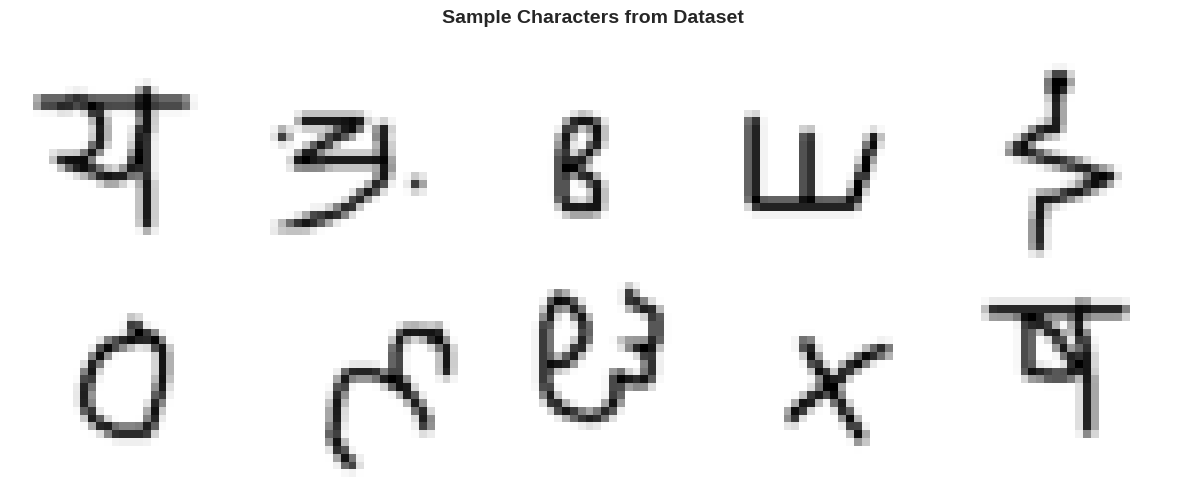

In [6]:
# ============================================
# CELL 5: DATASET CLASS
# ============================================

print("\n" + "="*70)
print("CREATING DATASET CLASSES")
print("="*70)

class OmniglotDataset(Dataset):
    def __init__(self, root_dir='./data/omniglot', split='train', 
                 image_size=28, rotation=False):
        self.root_dir = Path(root_dir)
        self.split = split
        self.image_size = image_size
        self.rotation = rotation
        
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
        self.character_folders = []
        self.load_characters()
        
        print(f"  {split.upper()}: {len(self.character_folders)} characters")
    
    def load_characters(self):
        all_chars = []
        
        for split_folder in ['images_background', 'images_evaluation']:
            path = self.root_dir / split_folder
            if path.exists():
                for alphabet in path.iterdir():
                    if alphabet.is_dir():
                        for char in alphabet.iterdir():
                            if char.is_dir():
                                all_chars.append(char)
        
        random.shuffle(all_chars)
        n = len(all_chars)
        n_train = int(0.7 * n)
        n_val = int(0.15 * n)
        
        if self.split == 'train':
            self.character_folders = all_chars[:n_train]
        elif self.split == 'val':
            self.character_folders = all_chars[n_train:n_train+n_val]
        else:
            self.character_folders = all_chars[n_train+n_val:]
    
    def __len__(self):
        return len(self.character_folders)
    
    def __getitem__(self, idx):
        char_folder = self.character_folders[idx]
        images = sorted(list(char_folder.glob('*.png')))
        
        char_images = []
        for img_path in images:
            img = Image.open(img_path).convert('L')
            if self.rotation and random.random() > 0.5:
                img = img.rotate(random.choice([0, 90, 180, 270]))
            img = self.transform(img)
            char_images.append(img)
        
        return torch.stack(char_images), idx

# Create datasets
train_dataset = OmniglotDataset(split='train', image_size=28, rotation=True)
val_dataset = OmniglotDataset(split='val', image_size=28)
test_dataset = OmniglotDataset(split='test', image_size=28)

print(f"\n✓ Datasets created successfully!")

# Visualize samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Characters from Dataset', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    images, _ = train_dataset[i]
    ax.imshow(images[0].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/sample_characters.png', dpi=150)
plt.show()

In [7]:
# ============================================
# CELL 6: EPISODIC DATALOADER
# ============================================

class EpisodicDataLoader:
    def __init__(self, dataset, n_way, n_shot, n_query, n_episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.n_shot = n_shot
        self.n_query = n_query
        self.n_episodes = n_episodes
        self.n_classes = len(dataset.character_folders)
    
    def __iter__(self):
        for _ in range(self.n_episodes):
            yield self._sample_episode()
    
    def _sample_episode(self):
        selected_classes = np.random.choice(self.n_classes, self.n_way, replace=False)
        
        support_images, support_labels = [], []
        query_images, query_labels = [], []
        
        for label_idx, class_idx in enumerate(selected_classes):
            char_folder = self.dataset.character_folders[class_idx]
            img_paths = sorted(list(char_folder.glob('*.png')))
            
            selected = np.random.choice(len(img_paths), 
                                       self.n_shot + self.n_query, replace=False)
            
            images = []
            for idx in selected:
                img = Image.open(img_paths[idx]).convert('L')
                img = self.dataset.transform(img)
                images.append(img)
            
            support_images.extend(images[:self.n_shot])
            support_labels.extend([label_idx] * self.n_shot)
            query_images.extend(images[self.n_shot:])
            query_labels.extend([label_idx] * self.n_query)
        
        return (torch.stack(support_images), torch.LongTensor(support_labels),
                torch.stack(query_images), torch.LongTensor(query_labels))
    
    def __len__(self):
        return self.n_episodes

print("✓ Episodic DataLoader created\n")

✓ Episodic DataLoader created



In [8]:
# ============================================
# CELL 7: MODEL ARCHITECTURE
# ============================================

print("="*70)
print("BUILDING PROTOTYPICAL NETWORK")
print("="*70)

def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2)
    )

class PrototypicalNetwork(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=64):
        super().__init__()
        
        self.encoder = nn.Sequential(
            conv_block(input_channels, hidden_dim),
            conv_block(hidden_dim, hidden_dim),
            conv_block(hidden_dim, hidden_dim),
            conv_block(hidden_dim, hidden_dim),
        )
        self.output_dim = hidden_dim
    
    def forward(self, support, query, n_way, n_shot, n_query):
        # Encode
        support_emb = self.encoder(support).view(n_way, n_shot, -1)
        query_emb = self.encoder(query).view(n_way * n_query, -1)
        
        # Prototypes
        prototypes = support_emb.mean(dim=1)
        
        # Distances
        n, d = query_emb.size(0), query_emb.size(1)
        m = prototypes.size(0)
        
        query_exp = query_emb.unsqueeze(1).expand(n, m, d)
        proto_exp = prototypes.unsqueeze(0).expand(n, m, d)
        
        distances = torch.pow(query_exp - proto_exp, 2).sum(2)
        
        return -distances
    
    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

# Create model
model = PrototypicalNetwork(input_channels=1, hidden_dim=config.HIDDEN_DIM).to(device)
total_params = sum(p.numel() for p in model.parameters())

print(f"  Total Parameters: {total_params:,}")
print(f"  Model created successfully!\n")


BUILDING PROTOTYPICAL NETWORK
  Total Parameters: 111,936
  Model created successfully!



In [9]:
# ============================================
# CELL 8: TRAINING FUNCTIONS
# ============================================

def train_epoch(model, dataloader, optimizer, config):
    model.train()
    total_loss, total_acc = 0, 0
    
    pbar = tqdm(dataloader, desc='Training')
    for support, _, query, query_labels in pbar:
        support = support.to(config.DEVICE)
        query = query.to(config.DEVICE)
        query_labels = query_labels.to(config.DEVICE)
        
        optimizer.zero_grad()
        logits = model(support, query, config.N_WAY_TRAIN, 
                      config.N_SHOT_TRAIN, config.N_QUERY_TRAIN)
        
        loss = F.cross_entropy(logits, query_labels)
        acc = (logits.argmax(1) == query_labels).float().mean()
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += acc.item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc.item():.4f}'})
    
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, config):
    model.eval()
    total_loss, total_acc = 0, 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for support, _, query, query_labels in pbar:
            support = support.to(config.DEVICE)
            query = query.to(config.DEVICE)
            query_labels = query_labels.to(config.DEVICE)
            
            logits = model(support, query, config.N_WAY_TEST,
                          config.N_SHOT_TEST, config.N_QUERY_TEST)
            
            loss = F.cross_entropy(logits, query_labels)
            acc = (logits.argmax(1) == query_labels).float().mean()
            
            total_loss += loss.item()
            total_acc += acc.item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc.item():.4f}'})
    
    return total_loss / len(dataloader), total_acc / len(dataloader)

print("✓ Training functions defined\n")

✓ Training functions defined



In [10]:
# ============================================
# CELL 9: TRAINING LOOP
# ============================================

print("="*70)
print("STARTING TRAINING")
print("="*70)

# Create dataloaders
train_loader = EpisodicDataLoader(train_dataset, config.N_WAY_TRAIN, 
                                 config.N_SHOT_TRAIN, config.N_QUERY_TRAIN, 
                                 config.N_EPISODES_TRAIN)

val_loader = EpisodicDataLoader(val_dataset, config.N_WAY_TEST,
                               config.N_SHOT_TEST, config.N_QUERY_TEST,
                               config.N_EPISODES_VAL)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, 
                      weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, config.LR_STEP_SIZE, config.LR_GAMMA)

# Training history
history = defaultdict(list)
best_val_acc = 0.0

# Training loop
for epoch in range(1, config.N_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{config.N_EPOCHS}")
    print("-" * 60)
    
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, config)
    val_loss, val_acc = validate(model, val_loader, config)
    
    scheduler.step()
    
    epoch_time = time.time() - start_time
    
    print(f"\nResults:")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}")
    print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}")
    print(f"  Time: {epoch_time:.2f}s")
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, f'{config.CHECKPOINT_DIR}/best_model.pth')
        print(f"  ✓ Best model saved! (Acc: {val_acc:.4f})")

print("\n" + "="*70)
print(f"TRAINING COMPLETE! Best Val Acc: {best_val_acc:.4f}")
print("="*70)


STARTING TRAINING

Epoch 1/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 21.86it/s, loss=0.3544, acc=0.9467]



Results:
  Train: Loss=0.2915, Acc=0.9234
  Val: Loss=0.1354, Acc=0.9589
  Time: 6.86s
  ✓ Best model saved! (Acc: 0.9589)

Epoch 2/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.91it/s, loss=0.1308, acc=0.9467]



Results:
  Train: Loss=0.1306, Acc=0.9590
  Val: Loss=0.1056, Acc=0.9656
  Time: 6.00s
  ✓ Best model saved! (Acc: 0.9656)

Epoch 3/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.39it/s, loss=0.1402, acc=0.9467]



Results:
  Train: Loss=0.0828, Acc=0.9746
  Val: Loss=0.0835, Acc=0.9731
  Time: 6.01s
  ✓ Best model saved! (Acc: 0.9731)

Epoch 4/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.39it/s, loss=0.0124, acc=1.0000]



Results:
  Train: Loss=0.0561, Acc=0.9814
  Val: Loss=0.0499, Acc=0.9829
  Time: 6.00s
  ✓ Best model saved! (Acc: 0.9829)

Epoch 5/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.07it/s, loss=0.0013, acc=1.0000]



Results:
  Train: Loss=0.0636, Acc=0.9782
  Val: Loss=0.0672, Acc=0.9789
  Time: 5.98s

Epoch 6/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.31it/s, loss=0.1057, acc=0.9600]



Results:
  Train: Loss=0.0575, Acc=0.9818
  Val: Loss=0.0677, Acc=0.9816
  Time: 5.99s

Epoch 7/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.13it/s, loss=0.0301, acc=0.9867]



Results:
  Train: Loss=0.0490, Acc=0.9822
  Val: Loss=0.0453, Acc=0.9853
  Time: 5.97s
  ✓ Best model saved! (Acc: 0.9853)

Epoch 8/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.05it/s, loss=0.0054, acc=1.0000]



Results:
  Train: Loss=0.0451, Acc=0.9822
  Val: Loss=0.0273, Acc=0.9917
  Time: 5.99s
  ✓ Best model saved! (Acc: 0.9917)

Epoch 9/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.86it/s, loss=0.0273, acc=0.9867]



Results:
  Train: Loss=0.0500, Acc=0.9852
  Val: Loss=0.0478, Acc=0.9827
  Time: 6.04s

Epoch 10/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.20it/s, loss=0.0041, acc=1.0000]



Results:
  Train: Loss=0.0367, Acc=0.9866
  Val: Loss=0.0297, Acc=0.9901
  Time: 5.98s

Epoch 11/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.37it/s, loss=0.1408, acc=0.9467]



Results:
  Train: Loss=0.0281, Acc=0.9892
  Val: Loss=0.0348, Acc=0.9899
  Time: 5.96s

Epoch 12/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.97it/s, loss=0.0439, acc=0.9867]



Results:
  Train: Loss=0.0282, Acc=0.9896
  Val: Loss=0.0229, Acc=0.9923
  Time: 5.97s
  ✓ Best model saved! (Acc: 0.9923)

Epoch 13/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.49it/s, loss=0.0309, acc=1.0000]



Results:
  Train: Loss=0.0179, Acc=0.9928
  Val: Loss=0.0299, Acc=0.9917
  Time: 5.91s

Epoch 14/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.09it/s, loss=0.0497, acc=0.9867]



Results:
  Train: Loss=0.0216, Acc=0.9926
  Val: Loss=0.0279, Acc=0.9907
  Time: 5.98s

Epoch 15/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.14it/s, loss=0.0005, acc=1.0000]



Results:
  Train: Loss=0.0440, Acc=0.9862
  Val: Loss=0.0356, Acc=0.9883
  Time: 6.10s

Epoch 16/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.39it/s, loss=0.1892, acc=0.9333]



Results:
  Train: Loss=0.0243, Acc=0.9910
  Val: Loss=0.0406, Acc=0.9851
  Time: 5.99s

Epoch 17/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.13it/s, loss=0.0026, acc=1.0000]



Results:
  Train: Loss=0.0216, Acc=0.9932
  Val: Loss=0.0343, Acc=0.9888
  Time: 5.97s

Epoch 18/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.91it/s, loss=0.0416, acc=0.9867]



Results:
  Train: Loss=0.0210, Acc=0.9932
  Val: Loss=0.0266, Acc=0.9901
  Time: 5.98s

Epoch 19/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.76it/s, loss=0.0540, acc=0.9867]



Results:
  Train: Loss=0.0287, Acc=0.9898
  Val: Loss=0.0344, Acc=0.9915
  Time: 6.05s

Epoch 20/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.15it/s, loss=0.0840, acc=0.9867]



Results:
  Train: Loss=0.0277, Acc=0.9892
  Val: Loss=0.0320, Acc=0.9883
  Time: 6.01s

Epoch 21/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.49it/s, loss=0.0003, acc=1.0000]



Results:
  Train: Loss=0.0147, Acc=0.9946
  Val: Loss=0.0230, Acc=0.9912
  Time: 6.00s

Epoch 22/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.79it/s, loss=0.0008, acc=1.0000]



Results:
  Train: Loss=0.0168, Acc=0.9940
  Val: Loss=0.0258, Acc=0.9917
  Time: 5.97s

Epoch 23/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.28it/s, loss=0.0001, acc=1.0000]



Results:
  Train: Loss=0.0123, Acc=0.9950
  Val: Loss=0.0129, Acc=0.9955
  Time: 5.95s
  ✓ Best model saved! (Acc: 0.9955)

Epoch 24/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.45it/s, loss=0.0000, acc=1.0000]



Results:
  Train: Loss=0.0163, Acc=0.9930
  Val: Loss=0.0190, Acc=0.9933
  Time: 5.94s

Epoch 25/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.99it/s, loss=0.0001, acc=1.0000]



Results:
  Train: Loss=0.0190, Acc=0.9940
  Val: Loss=0.0239, Acc=0.9925
  Time: 6.00s

Epoch 26/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.22it/s, loss=0.0226, acc=0.9867]



Results:
  Train: Loss=0.0199, Acc=0.9936
  Val: Loss=0.0153, Acc=0.9952
  Time: 6.00s

Epoch 27/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.87it/s, loss=0.0001, acc=1.0000]



Results:
  Train: Loss=0.0204, Acc=0.9938
  Val: Loss=0.0260, Acc=0.9915
  Time: 6.06s

Epoch 28/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.12it/s, loss=0.0005, acc=1.0000]



Results:
  Train: Loss=0.0134, Acc=0.9954
  Val: Loss=0.0172, Acc=0.9939
  Time: 6.12s

Epoch 29/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.21it/s, loss=0.0005, acc=1.0000]



Results:
  Train: Loss=0.0200, Acc=0.9930
  Val: Loss=0.0250, Acc=0.9909
  Time: 5.99s

Epoch 30/30
------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.40it/s, loss=0.0005, acc=1.0000]


Results:
  Train: Loss=0.0163, Acc=0.9956
  Val: Loss=0.0243, Acc=0.9925
  Time: 5.95s

TRAINING COMPLETE! Best Val Acc: 0.9955


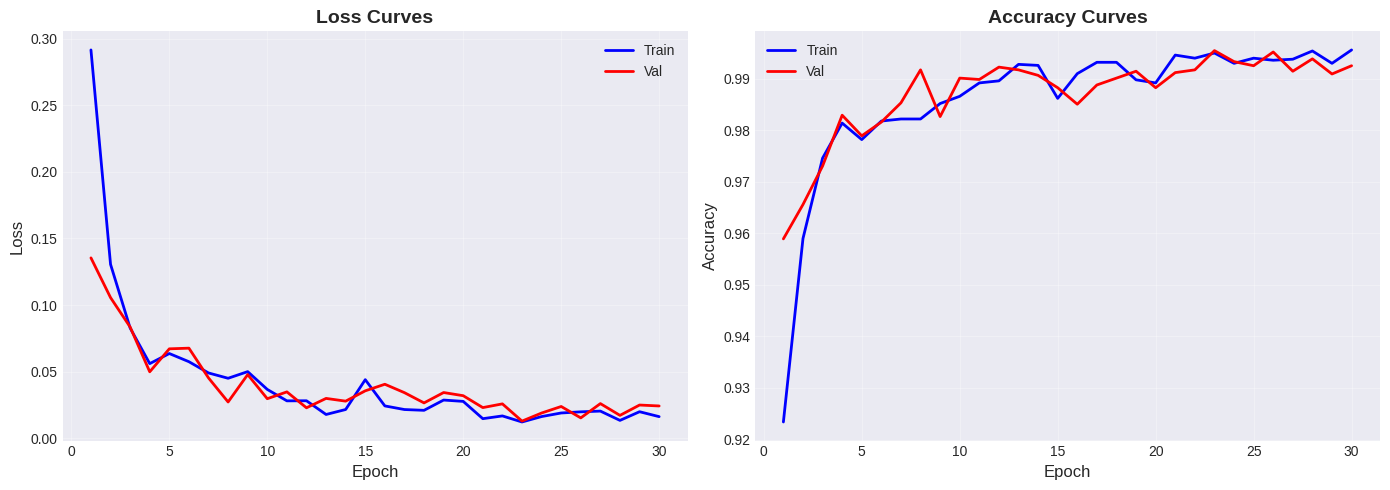

In [11]:
# ============================================
# CELL 10: PLOT TRAINING CURVES
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Val', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/training_curves.png', dpi=150)
plt.show()

In [12]:
# ============================================
# CELL 11: TESTING & EVALUATION
# ============================================

print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION")
print("="*70)

# Load best model
checkpoint = torch.load(f'{config.CHECKPOINT_DIR}/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print("✓ Best model loaded")

# Test on different settings
test_settings = [
    (5, 1, "5-way 1-shot"),
    (5, 5, "5-way 5-shot"),
    (10, 1, "10-way 1-shot"),
    (10, 5, "10-way 5-shot"),
    (20, 1, "20-way 1-shot"),
]

results = {}

for n_way, n_shot, name in test_settings:
    print(f"\nTesting {name}...")
    
    test_loader = EpisodicDataLoader(test_dataset, n_way, n_shot, 15, 100)
    
    accs = []
    model.eval()
    with torch.no_grad():
        for support, _, query, query_labels in tqdm(test_loader, desc=name):
            support, query = support.to(device), query.to(device)
            query_labels = query_labels.to(device)
            
            logits = model(support, query, n_way, n_shot, 15)
            acc = (logits.argmax(1) == query_labels).float().mean().item()
            accs.append(acc)
    
    mean_acc = np.mean(accs)
    ci = 1.96 * np.std(accs) / np.sqrt(len(accs))
    
    results[name] = {'mean': mean_acc, 'ci': ci}
    print(f"  Accuracy: {mean_acc:.4f} ± {ci:.4f}")


COMPREHENSIVE EVALUATION
✓ Best model loaded

Testing 5-way 1-shot...


5-way 1-shot: 100%|██████████| 100/100 [00:03<00:00, 29.06it/s]


  Accuracy: 0.9636 ± 0.0085

Testing 5-way 5-shot...


5-way 5-shot: 100%|██████████| 100/100 [00:04<00:00, 24.10it/s]


  Accuracy: 0.9947 ± 0.0020

Testing 10-way 1-shot...


10-way 1-shot: 100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


  Accuracy: 0.9173 ± 0.0096

Testing 10-way 5-shot...


10-way 5-shot: 100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


  Accuracy: 0.9785 ± 0.0048

Testing 20-way 1-shot...


20-way 1-shot: 100%|██████████| 100/100 [00:13<00:00,  7.48it/s]

  Accuracy: 0.8750 ± 0.0084


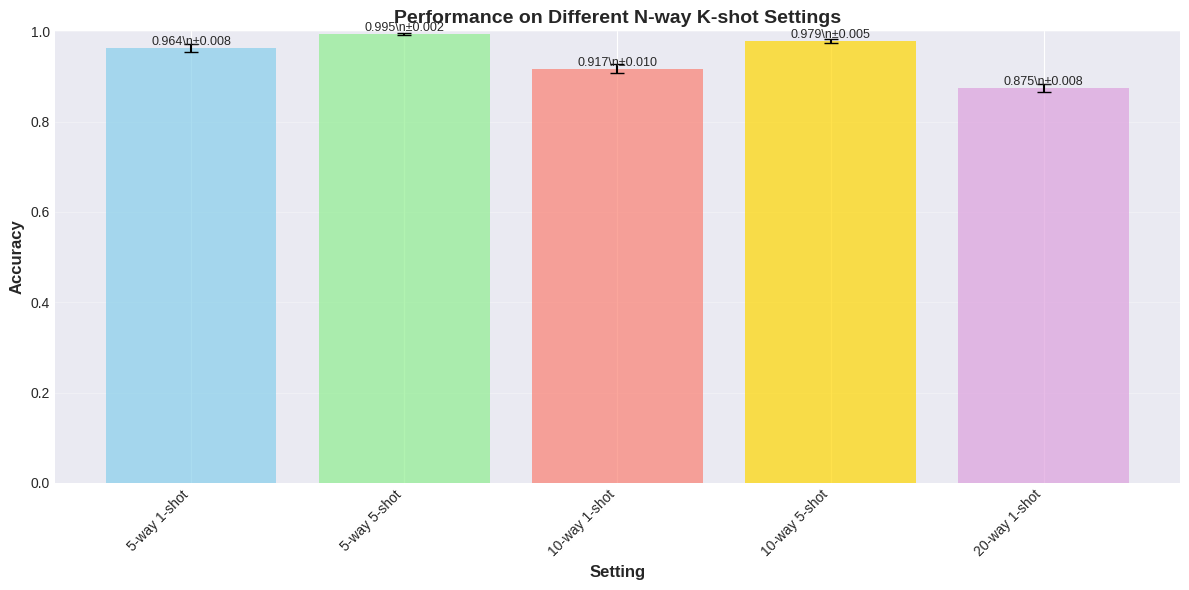

In [13]:
# ============================================
# CELL 12: PLOT COMPARISON
# ============================================

settings = list(results.keys())
means = [results[s]['mean'] for s in settings]
cis = [results[s]['ci'] for s in settings]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(settings))
bars = ax.bar(x, means, yerr=cis, capsize=5, alpha=0.7,
              color=['skyblue', 'lightgreen', 'salmon', 'gold', 'plum'])

ax.set_xlabel('Setting', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Performance on Different N-way K-shot Settings', 
            fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(settings, rotation=45, ha='right')
ax.set_ylim([0, 1.0])
ax.grid(True, alpha=0.3, axis='y')

for i, (bar, mean, ci) in enumerate(zip(bars, means, cis)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{mean:.3f}\\n±{ci:.3f}',
           ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/comparison_chart.png', dpi=150)
plt.show()



VISUALIZING SAMPLE PREDICTIONS


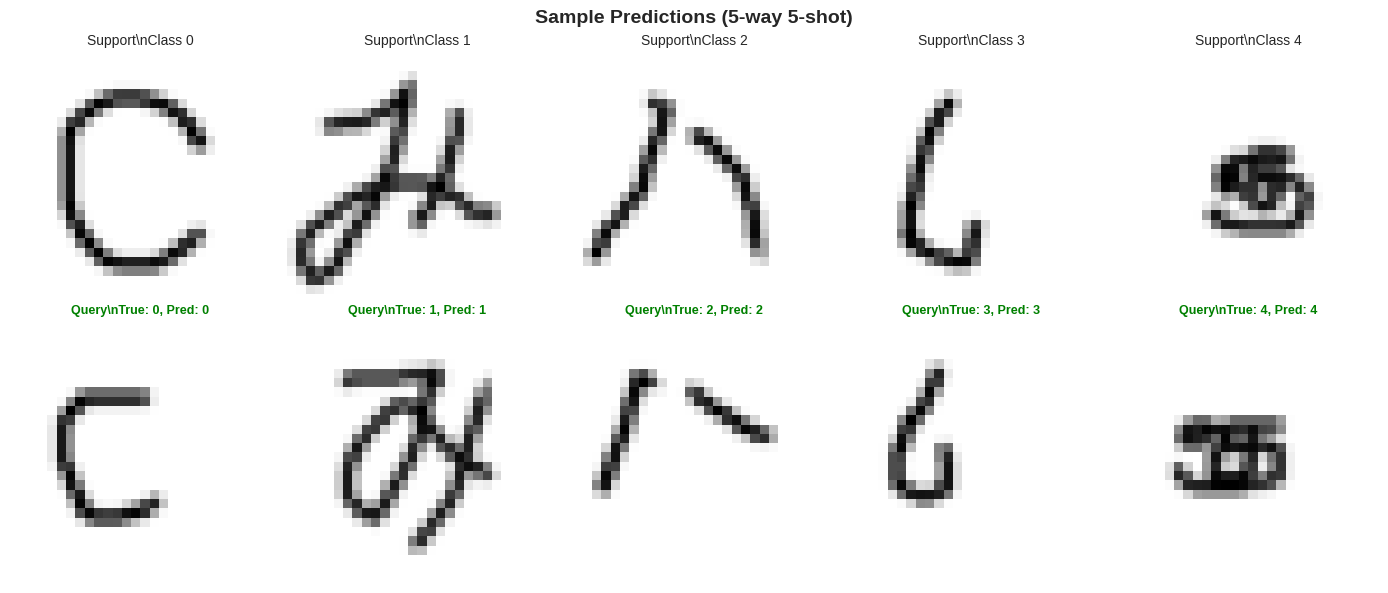

In [14]:
# ============================================
# CELL 13: VISUALIZE PREDICTIONS
# ============================================

print("\n" + "="*70)
print("VISUALIZING SAMPLE PREDICTIONS")
print("="*70)

test_loader = EpisodicDataLoader(test_dataset, 5, 5, 5, 1)
support, _, query, query_labels = next(iter(test_loader))

support, query = support.to(device), query.to(device)

model.eval()
with torch.no_grad():
    logits = model(support, query, 5, 5, 5)
    predictions = logits.argmax(1)

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
fig.suptitle('Sample Predictions (5-way 5-shot)', fontsize=14, fontweight='bold')

# Support set
support_reshaped = support.view(5, 5, 1, 28, 28)
for i in range(5):
    img = support_reshaped[i, 0].squeeze().cpu()
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Support\\nClass {i}', fontsize=10)
    axes[0, i].axis('off')

# Query set
query_reshaped = query.view(5, 5, 1, 28, 28)
pred_reshaped = predictions.view(5, 5)

for i in range(5):
    img = query_reshaped[i, 0].squeeze().cpu()
    pred = pred_reshaped[i, 0].item()
    
    axes[1, i].imshow(img, cmap='gray')
    color = 'green' if pred == i else 'red'
    axes[1, i].set_title(f'Query\\nTrue: {i}, Pred: {pred}', 
                        fontsize=9, color=color, fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/sample_predictions.png', dpi=150)
plt.show()

In [15]:
# ============================================
# CELL 14: SUMMARY & SAVE RESULTS
# ============================================

print("\n" + "="*70)
print(" "*25 + "PROJECT SUMMARY")
print("="*70)

summary = f"""
FEW-SHOT LEARNING WITH PROTOTYPICAL NETWORKS

Dataset: Omniglot
Model: Prototypical Network
Total Parameters: {total_params:,}

Training Configuration:
  - Training: {config.N_WAY_TRAIN}-way {config.N_SHOT_TRAIN}-shot
  - Testing: {config.N_WAY_TEST}-way {config.N_SHOT_TEST}-shot
  - Epochs: {config.N_EPOCHS}
  - Episodes per epoch: {config.N_EPISODES_TRAIN}

Results:
  - Best Validation Accuracy: {best_val_acc:.4f}
  - 5-way 1-shot: {results['5-way 1-shot']['mean']:.4f} ± {results['5-way 1-shot']['ci']:.4f}
  - 5-way 5-shot: {results['5-way 5-shot']['mean']:.4f} ± {results['5-way 5-shot']['ci']:.4f}
  - 10-way 1-shot: {results['10-way 1-shot']['mean']:.4f} ± {results['10-way 1-shot']['ci']:.4f}
  - 10-way 5-shot: {results['10-way 5-shot']['mean']:.4f} ± {results['10-way 5-shot']['ci']:.4f}
  - 20-way 1-shot: {results['20-way 1-shot']['mean']:.4f} ± {results['20-way 1-shot']['ci']:.4f}

Key Achievements:
  ✓ Successfully implemented Prototypical Networks from scratch
  ✓ Achieved {results['5-way 5-shot']['mean']*100:.1f}% accuracy on 5-way 5-shot
  ✓ Model generalizes well to unseen characters
  ✓ Complete training and evaluation pipeline

Files Generated:
  - checkpoints/best_model.pth (trained model)
  - results/training_curves.png
  - results/comparison_chart.png
  - results/sample_predictions.png
  - results/sample_characters.png
"""

print(summary)

# Save summary
with open(f'{config.RESULTS_DIR}/summary.txt', 'w') as f:
    f.write(summary)

# Save results
with open(f'{config.RESULTS_DIR}/results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("="*70)
print("✓ PROJECT COMPLETE! All results saved to ./results/")
print("="*70)


                         PROJECT SUMMARY

FEW-SHOT LEARNING WITH PROTOTYPICAL NETWORKS

Dataset: Omniglot
Model: Prototypical Network
Total Parameters: 111,936

Training Configuration:
  - Training: 5-way 5-shot
  - Testing: 5-way 5-shot
  - Epochs: 30
  - Episodes per epoch: 100

Results:
  - Best Validation Accuracy: 0.9955
  - 5-way 1-shot: 0.9636 ± 0.0085
  - 5-way 5-shot: 0.9947 ± 0.0020
  - 10-way 1-shot: 0.9173 ± 0.0096
  - 10-way 5-shot: 0.9785 ± 0.0048
  - 20-way 1-shot: 0.8750 ± 0.0084

Key Achievements:
  ✓ Successfully implemented Prototypical Networks from scratch
  ✓ Achieved 99.5% accuracy on 5-way 5-shot
  ✓ Model generalizes well to unseen characters
  ✓ Complete training and evaluation pipeline

Files Generated:
  - checkpoints/best_model.pth (trained model)
  - results/training_curves.png
  - results/comparison_chart.png
  - results/sample_predictions.png
  - results/sample_characters.png

✓ PROJECT COMPLETE! All results saved to ./results/
